In [ ]:
!pip install tensorflow tensorflow_hub numpy pandas matplotlib

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

# Nettoyage et Visualisation des données

In [39]:
df = pd.read_csv(
    'dataset/wine-reviews.csv', 
    usecols=['country', 'description', 'points', 'price', 'variety', 'winery']
)
print(df.shape)
df.head()

(129971, 6)


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


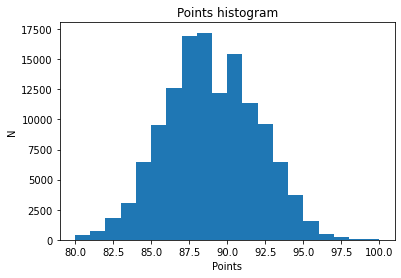

In [40]:
df = df.dropna(subset=['description', 'points'])

plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show();

df['points'].describe()

on peut remarquer que les données vont de 80 à 100, on peut donc avoir deux catégories de points ceux en dessus de 90 et au dessus de 90

In [43]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'points', 'label']]

# Apprentissage Automatique

In [46]:
train, valid, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [49]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df['description']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

## Modèle

In [72]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

hub_layer(list(train_data)[0][0])

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [73]:
model.evaluate(train_data)

102/102 [==============================] - 1s 7ms/step - loss: 0.7179 - accuracy: 0.3861


[0.7179276943206787, 0.3861083388328552]

In [74]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 36s 351ms/step - loss: 0.6224 - accuracy: 0.6381 - val_loss: 0.4808 - val_accuracy: 0.7886
Epoch 2/5
102/102 [==============================] - 36s 351ms/step - loss: 0.4629 - accuracy: 0.7798 - val_loss: 0.3980 - val_accuracy: 0.8153
Epoch 3/5
102/102 [==============================] - 36s 348ms/step - loss: 0.3966 - accuracy: 0.8287 - val_loss: 0.3772 - val_accuracy: 0.8265
Epoch 4/5
102/102 [==============================] - 36s 349ms/step - loss: 0.3628 - accuracy: 0.8475 - val_loss: 0.3725 - val_accuracy: 0.8311
Epoch 5/5
102/102 [==============================] - 36s 348ms/step - loss: 0.3367 - accuracy: 0.8603 - val_loss: 0.3733 - val_accuracy: 0.8303


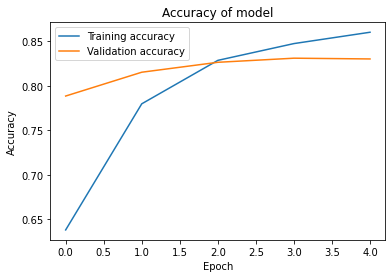

In [75]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title("Accuracy of model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show();

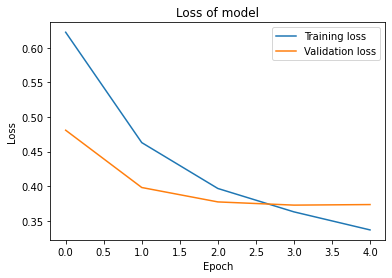

In [76]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss of model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show();